In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rioplt
from shapely.geometry import Point

In [2]:
file = nc.Dataset("dades/DADES_CALIOPE_buenos/NO2/sconcno2_2023010100.nc")
#sf = shp.Reader("dades/LimitsAdministratius/Catalunya/divisions-administratives-v2r1-catalunya-5000-20240705")
div_gdf = gpd.read_file("dades/LimitsAdministratius/Catalunya/divisions-administratives-v2r1-catalunya-5000-20240705.shp")
lu = rio.open("dades/LandUse/MUCSC_2022_10_m_v_3.tif")

In [115]:
print(file['sconcno2'])

<class 'netCDF4.Variable'>
float32 sconcno2(time, lev, y, x)
    units: ppm
    coordinates: lat lon
    grid_mapping: Lambert_conformal
unlimited dimensions: 
current shape = (48, 1, 298, 278)
filling on, default _FillValue of 9.969209968386869e+36 used


(25949, 26940)


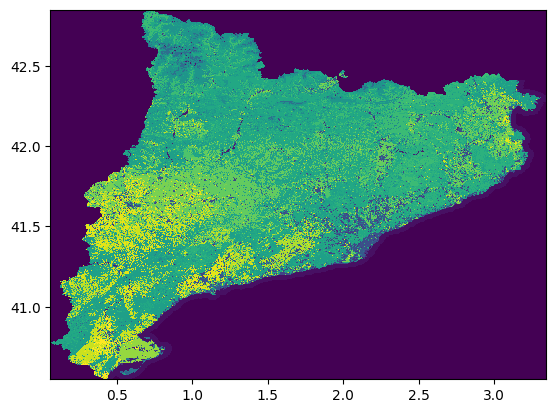

In [130]:
#lu_x = [(lu.transform * (i, 0))[0] for i in range(lu.width)]
lu_x = np.vectorize(lambda x: (lu.transform * (x, 0))[0])(np.arange(max(lu.width, lu.height)))
lu_y = np.vectorize(lambda y: (lu.transform * (0, y))[1])(np.arange(max(lu.height, lu.width)))
lu_gdf = gpd.GeoDataFrame(
    {'geometry': [Point(lon, lat) for lon, lat in zip(lu_x, lu_y)]},
    crs="EPSG:25831"
)
lu_gdf = lu_gdf.to_crs(4326)
lu_lon = lu_gdf.geometry.x.to_numpy()[:lu.width]
lu_lat = lu_gdf.geometry.y.to_numpy()[:lu.height]
lu_dat = lu.read(1)
print(lu_dat.shape)
plt.pcolormesh(lu_lon[::50], lu_lat[::50], lu_dat[::50, ::50])
plt.show()

In [105]:
lu_ponderacions = np.ones(25)
# INFRAESTRUCTURES VIARIES
lu_ponderacions[3] = 2
# URBANITZACIONS
lu_ponderacions[4] = 1.5
# ZONES URBANES
lu_ponderacions[5] = 2
# ZONES INDUSTRIALS I COMERCIALS
lu_ponderacions[6] = 2.5
print(lu_ponderacions)

[1.  1.  1.  2.  1.5 2.  2.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1. ]


In [135]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def predict(lon, lat, data):
    #lon = file['lon'][x][y]
    #lat = file['lat'][x][y]
    lu_lon_i = find_nearest(lu_lon, lon)
    lu_lat_i = find_nearest(lu_lat, lat)
    return data*lu_ponderacions[lu_dat[lu_lat_i][lu_lon_i]]
predictv = np.vectorize(predict)
def predictvv(lon, lat, data):
    
    for loni, lati, datai in zip(lon, lat, data):
        predictv(loni, lati, datai)
predictv(file['lon'][100], file['lat'][100], file['sconcno2'][0][0][100])-file['sconcno2'][0][0][100]
predictvv(file['lon'], file['lat'], file['sconcno2'][0][0])-file['sconcno2'][0][0]

TypeError: __array__() takes exactly 0 positional arguments (1 given)

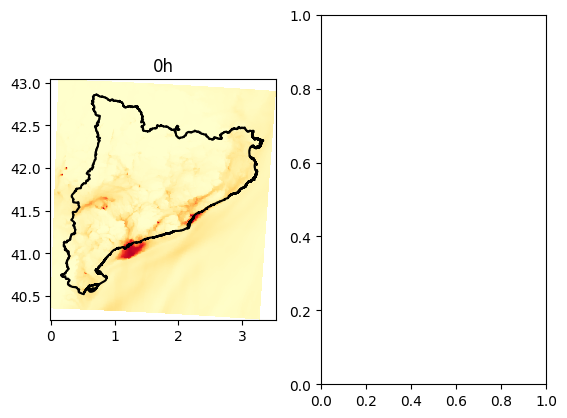

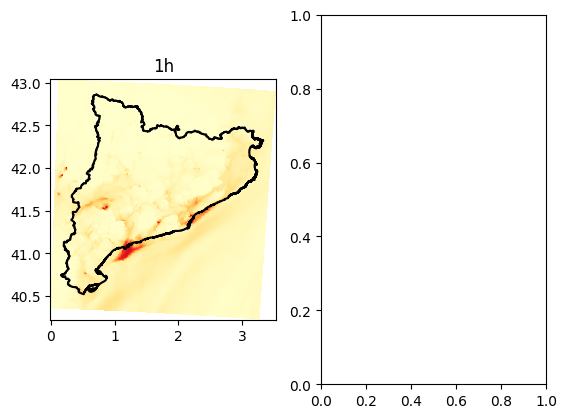

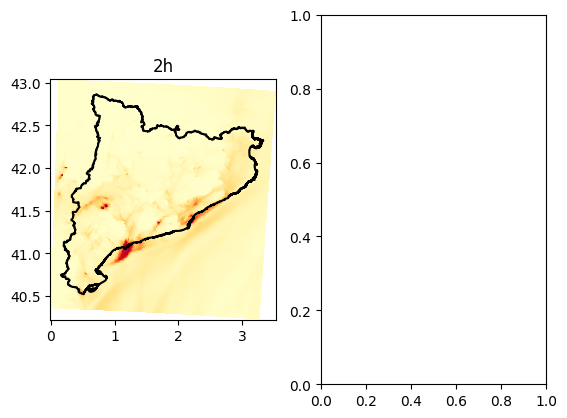

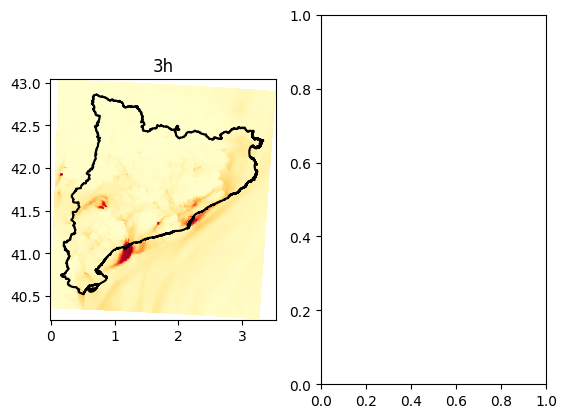

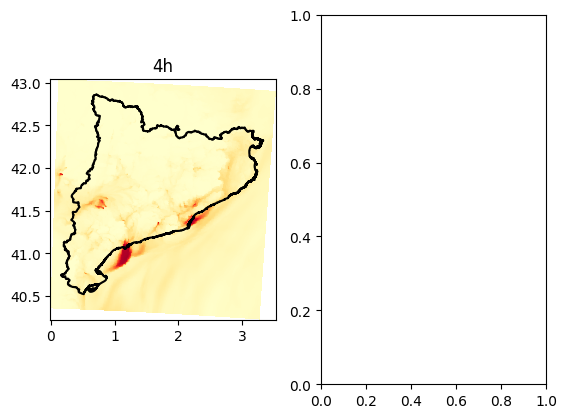

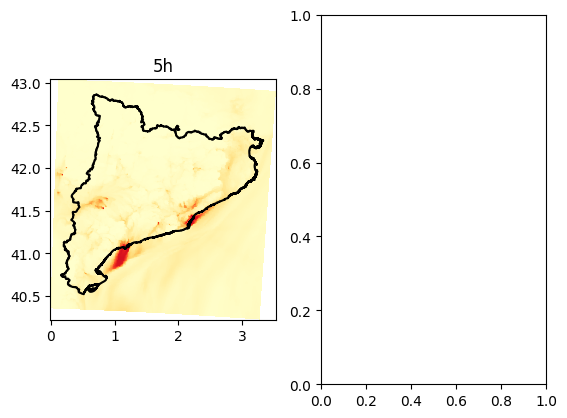

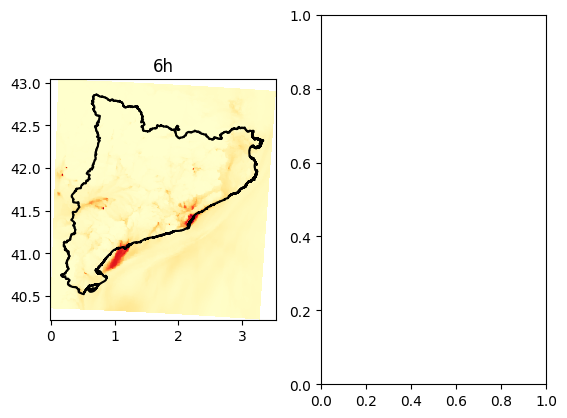

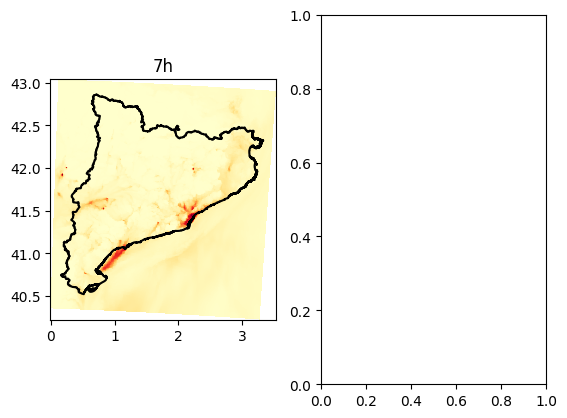

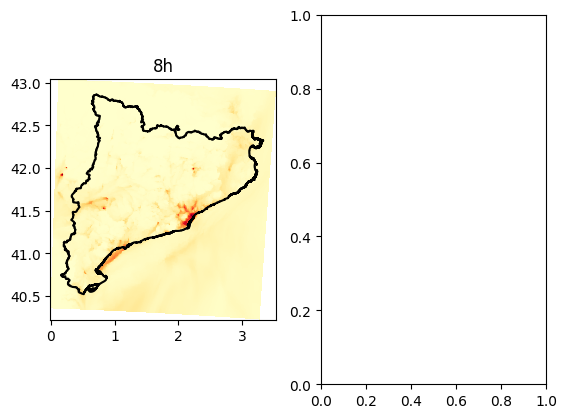

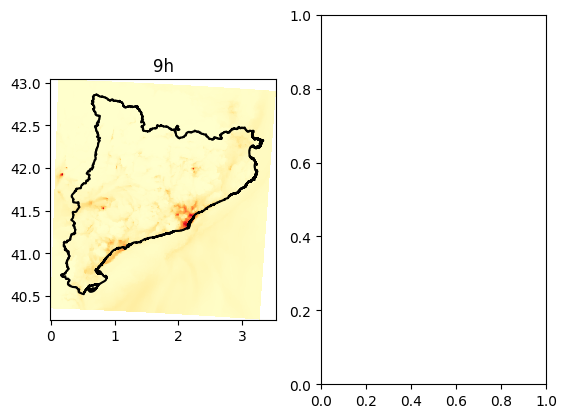

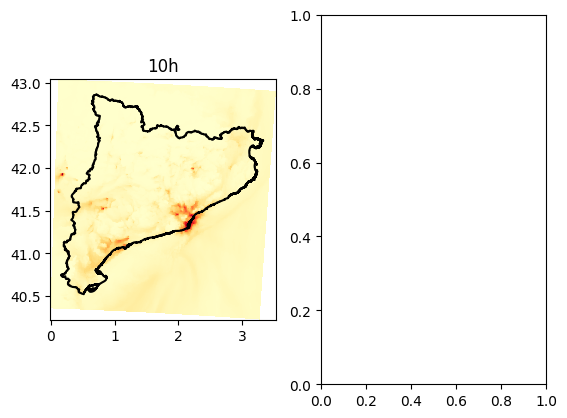

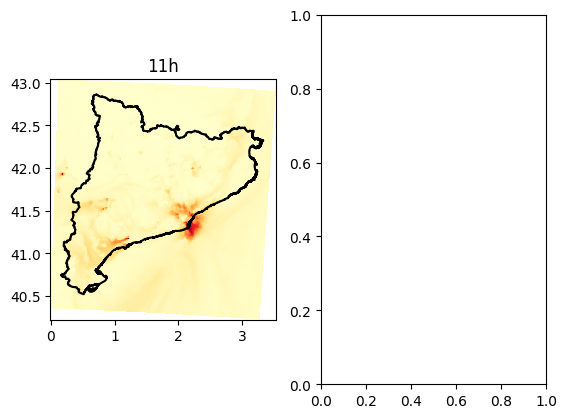

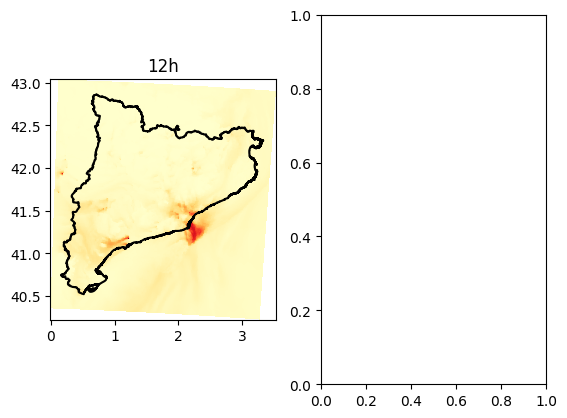

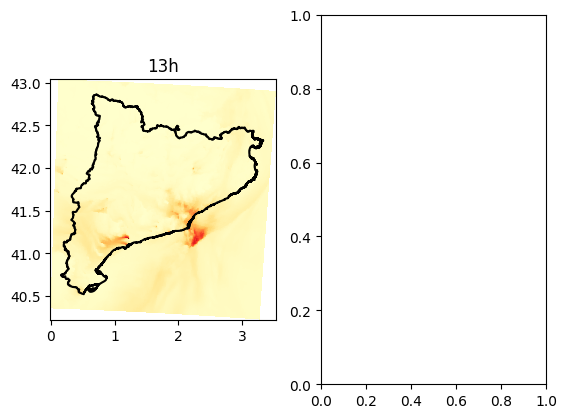

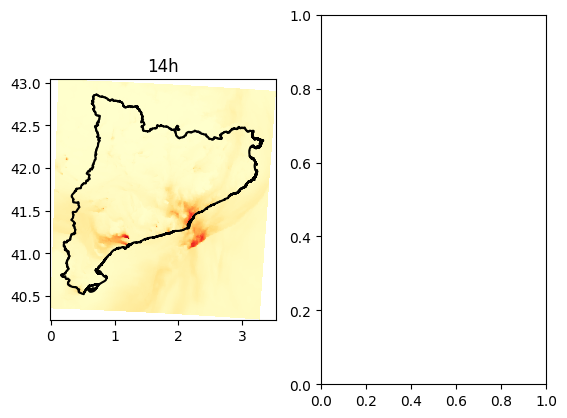

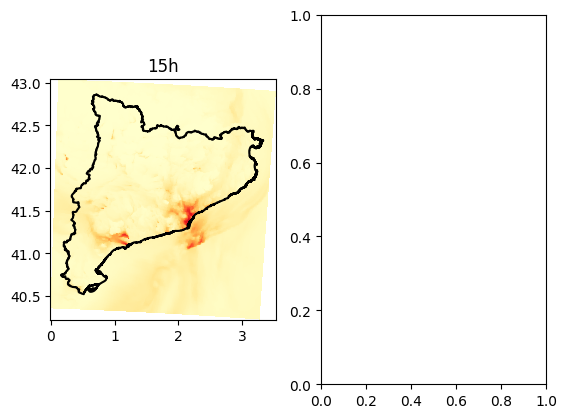

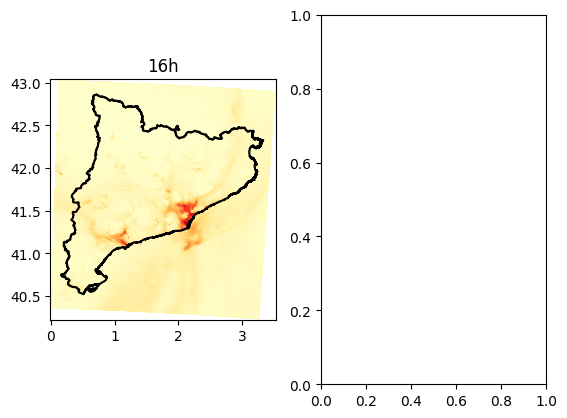

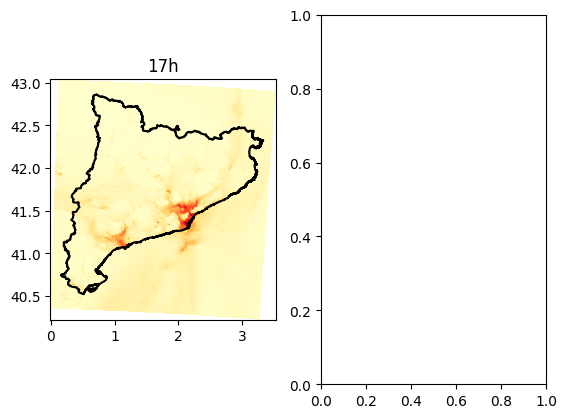

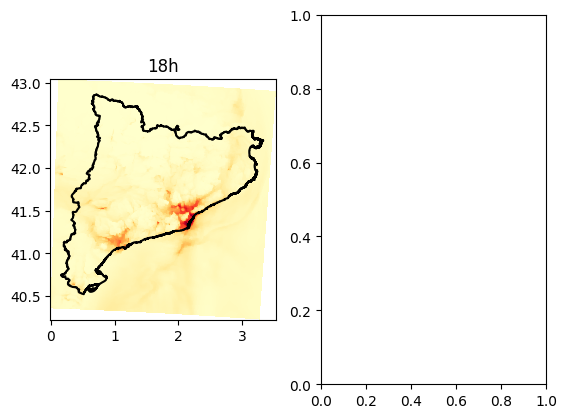

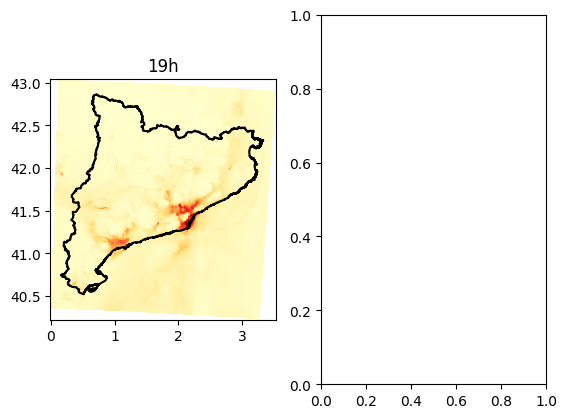

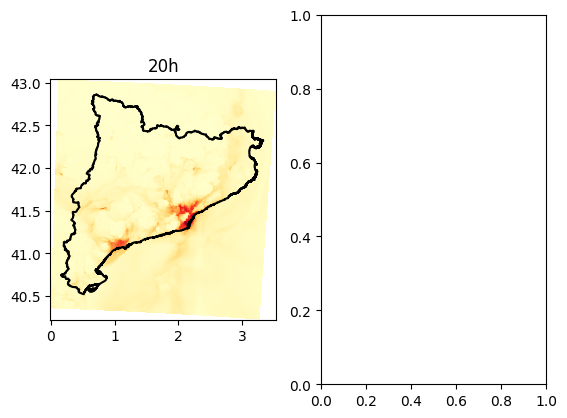

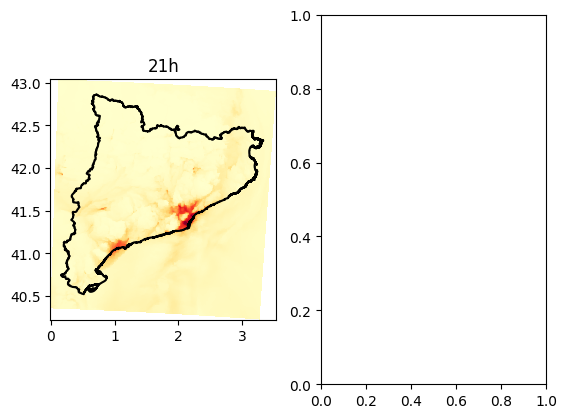

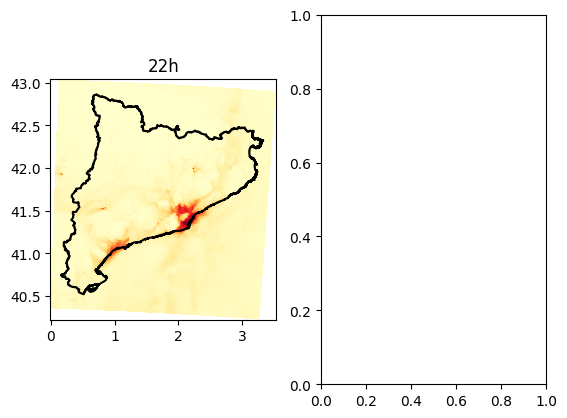

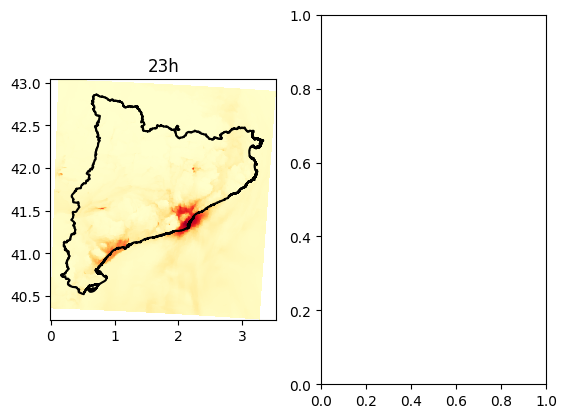

In [74]:
for h, data in enumerate(file['sconcno2'][0:24]):
    fig, ax = plt.subplots(1, 2)
    ax[0].set_title(f"{h % 24}h")
    ax[0].pcolormesh(file['lon'], file['lat'], data[0], cmap='YlOrRd')
    div_gdf.to_crs(4326).boundary.plot(ax=ax[0], color='k')
    plt.show()